In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        #ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        #ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        #ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        #ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # right

    return ax

In [36]:
def josui_gesui(city_num, left, right, bottom, top):
    #
    rgndir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region'
    glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    #
    resolution = 12
    POP='vld_cty_'
    #
    SUF = '.gl5'
    dtype = 'float32'
    gl5shape = (2160, 4320)
    #
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # city mask file
    citymask = np.fromfile(f'{glbdir}/dat/{POP}/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    citymask_cropped = citymask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    citymask_cropped = np.ma.masked_where(citymask_cropped == 0, citymask_cropped)
    # plot
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection=projection)
    ax1.coastlines()
    im = ax1.imshow(citymask_cropped, extent=img_extent, transform=projection, cmap='gray_r', vmin=0, vmax=3)
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # josui file
    josui = np.fromfile(f'{glbdir}/dat/cty_prf_/{POP}/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    josui_cropped = josui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    josui_cropped = np.ma.masked_where(josui_cropped == 0, josui_cropped)
    # plot
    #josui_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
    josui_cmap = plt.cm.colors.ListedColormap(['blue', 'blue'])
    js = ax1.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=josui_cmap)
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # gesui file
    gesui = np.fromfile(f'{glbdir}/dat/cty_swg_/{POP}/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    gesui_cropped = gesui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    gesui_cropped = np.ma.masked_where(gesui_cropped == 0, gesui_cropped)
    # plot
    #gesui_cmap = plt.cm.colors.ListedColormap(['white', 'red'])
    gesui_cmap = plt.cm.colors.ListedColormap(['red', 'red'])
    gs = ax1.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=gesui_cmap)
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # intake file
    #intake = np.fromfile(f'{glbdir}/dat/cty_int_/{POP}/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    intake = np.fromfile(f'{glbdir}/dat/cty_int_/vld_cty_samebasin/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    intake_cropped = np.ma.masked_where(intake_cropped == 0, intake_cropped)
    print(np.where(intake_cropped==1))
    # plot
    #intake_cmap = plt.cm.colors.ListedColormap(['white', 'green'])
    intake_cmap = plt.cm.colors.ListedColormap(['lime', 'lime'])
    it = ax1.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=intake_cmap)
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # rivout file
    rivout = np.fromfile(f'{glbdir}/dat/riv_out_/W5E5LR__20190000{SUF}', dtype='float32').reshape(gl5shape)
    # crop
    rivout_cropped = rivout[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

    ax2 = fig.add_subplot(1, 2, 2, projection=projection)
    ax2.coastlines()
    im = ax2.imshow(rivout_cropped, extent=img_extent, transform=projection, cmap='ocean_r')

    plt.show()

In [49]:
def int_samebasin(city_num, left, right, bottom, top):
    #
    rgndir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region'
    glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    #
    resolution = 12
    POP='vld_cty_'
    #
    SUF = '.gl5'
    dtype = 'float32'
    gl5shape = (2160, 4320)
    #
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # plot
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(projection=projection)
    
    ax.set_extent(img_extent, projection)
    gl = ax.gridlines(draw_labels=True, zorder=0)
    gl.right_labels = False
    gl.botoom_labels = False
    ax.add_feature(cfea.OCEAN, color='#BBBBBB')
    ax.add_feature(cfea.LAKES, color='#BBBBBB')
    ax.coastlines(zorder=1)

    #------------------------------------------------------------------------------------------------------------------------
    
    # rivout file
    # in kg/s, then should be (rivout*3600*24*365/1000) in m3/year
    rivout = np.fromfile(f'{glbdir}/dat/riv_out_/W5E5LR__20190000{SUF}', dtype='float32').reshape(gl5shape)
    # crop
    rivout_cropped = rivout[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    dis_vmin = np.min(rivout_masked)
    dis_vmax = np.max(rivout_masked)
    
    ds = ax.imshow(rivout_masked, extent=img_extent, transform=projection, 
                   #cmap='YlGnBu')
                   cmap='ocean_r')
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # city mask file
    citymask = np.fromfile(f'{glbdir}/dat/{POP}/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    citymask_cropped = citymask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    
    stw = draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='black')
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # josui file
    josui = np.fromfile(f'{glbdir}/dat/cty_prf_/{POP}/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    josui_cropped = josui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    josui_masked = np.ma.masked_where(josui_cropped == 0, josui_cropped)
    # plot
    josui_cmap = plt.cm.colors.ListedColormap(['blue', 'blue'])
    js = ax.imshow(josui_masked, extent=img_extent, transform=projection, cmap=josui_cmap)
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # gesui file
    gesui = np.fromfile(f'{glbdir}/dat/cty_swg_/{POP}/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    gesui_cropped = gesui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    gesui_masked = np.ma.masked_where(gesui_cropped == 0, gesui_cropped)
    # plot
    gesui_cmap = plt.cm.colors.ListedColormap(['red', 'red'])
    gs = ax.imshow(gesui_masked, extent=img_extent, transform=projection, cmap=gesui_cmap)
    
    #------------------------------------------------------------------------------------------------------------------------
    
    # intake file
    intake = np.fromfile(f'{glbdir}/dat/cty_int_/vld_cty_samebasin/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)
    # crop
    intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
    intake_cropped = np.ma.masked_where(intake_cropped == 0, intake_cropped)
    print(np.where(intake_cropped==1))
    # plot
    intake_cmap = plt.cm.colors.ListedColormap(['lime', 'lime'])
    it = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=intake_cmap)
    
    #------------------------------------------------------------------------------------------------------------------------

    fig.colorbar(ds, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)

    plt.show()

(array([22]), array([23]))


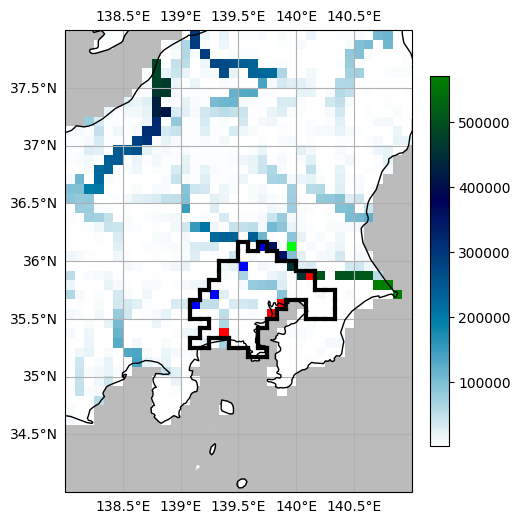

(array([22]), array([23]))


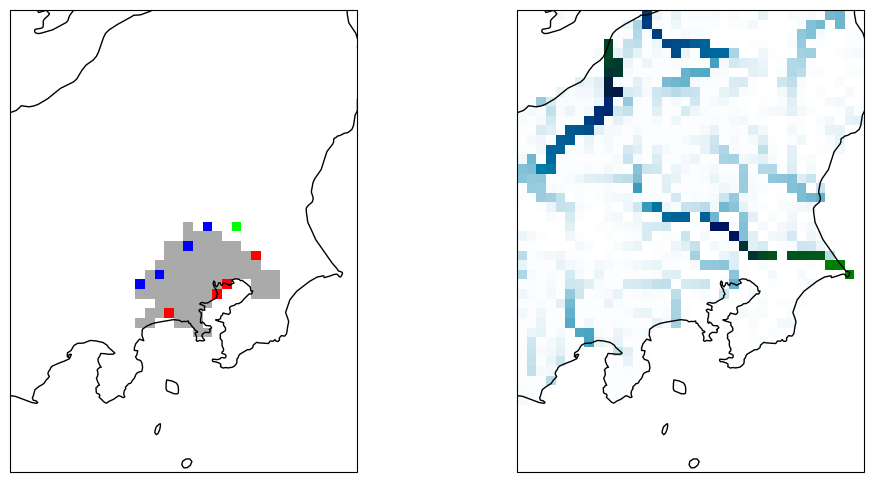

In [57]:
city_num = 1
left = 138
right = 141
bottom = 34
top = 38
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)

(array([], dtype=int64), array([], dtype=int64))


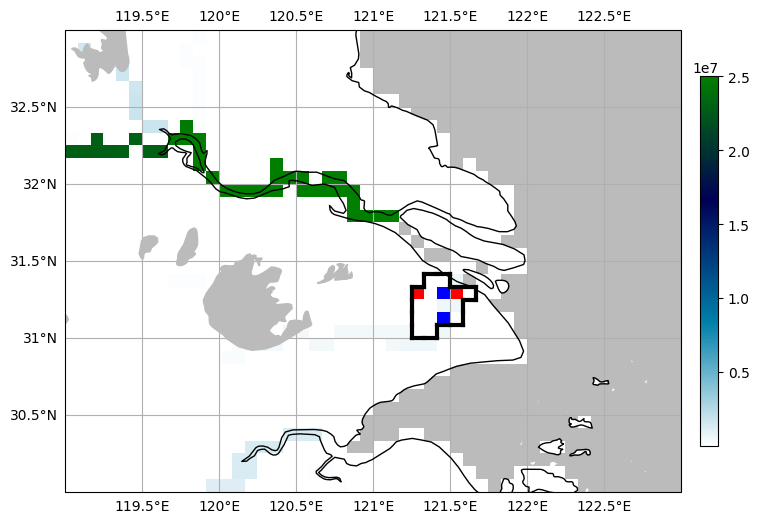

(array([], dtype=int64), array([], dtype=int64))


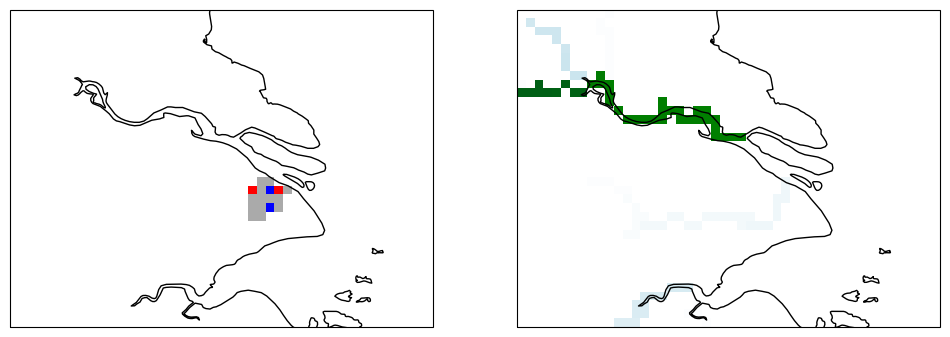

In [50]:
city_num = 3
left = 119
right = 123
bottom = 30
top = 33
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)

(array([14]), array([18]))


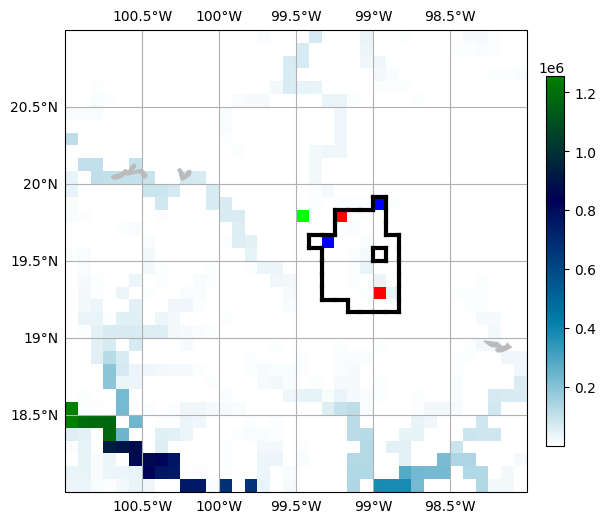

(array([14]), array([18]))


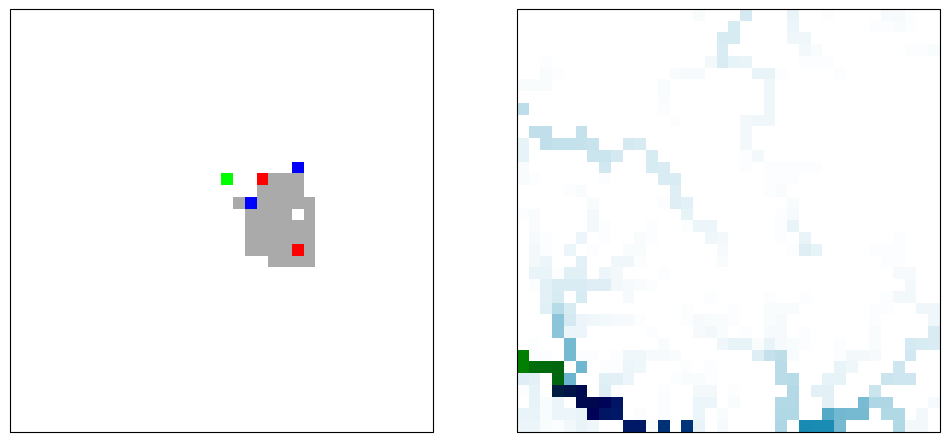

In [51]:
city_num = 4
left = -101
right = -98
bottom = 18
top = 21
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)

(array([21]), array([17]))


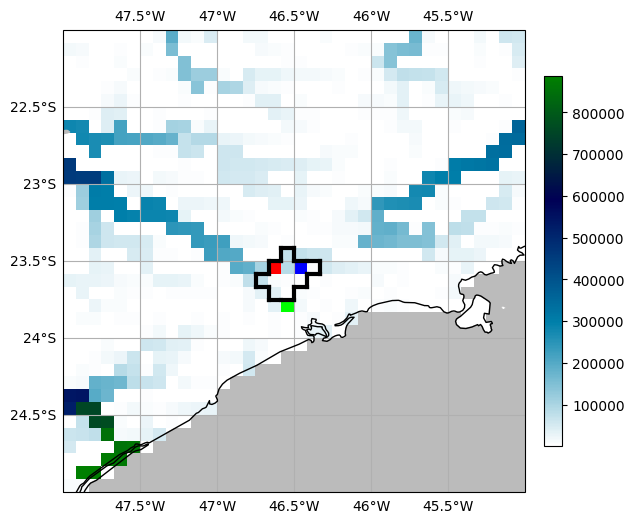

(array([21]), array([17]))


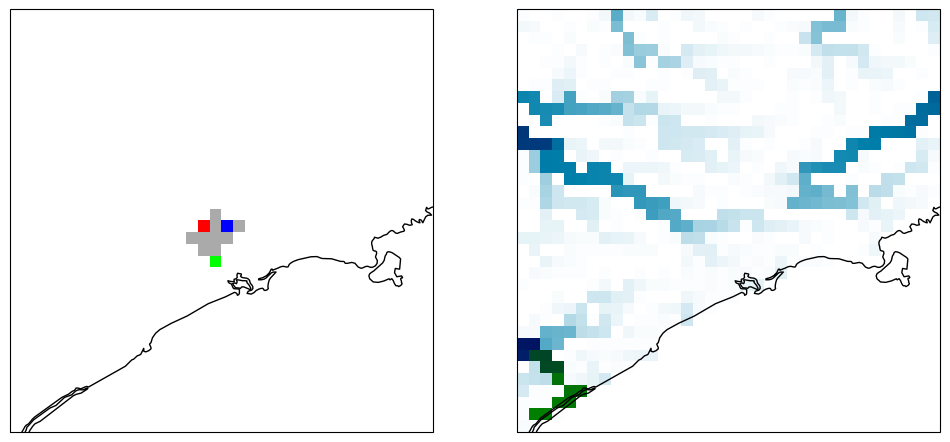

In [52]:
city_num = 5
left = -48
right = -45
bottom = -25
top = -22
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)

(array([13]), array([22]))


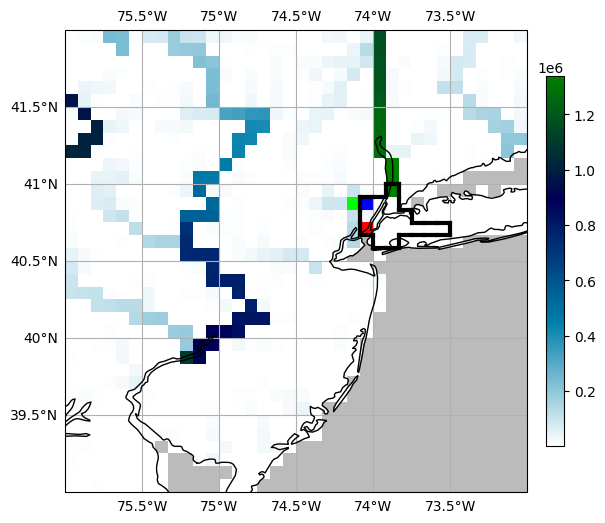

(array([13]), array([22]))


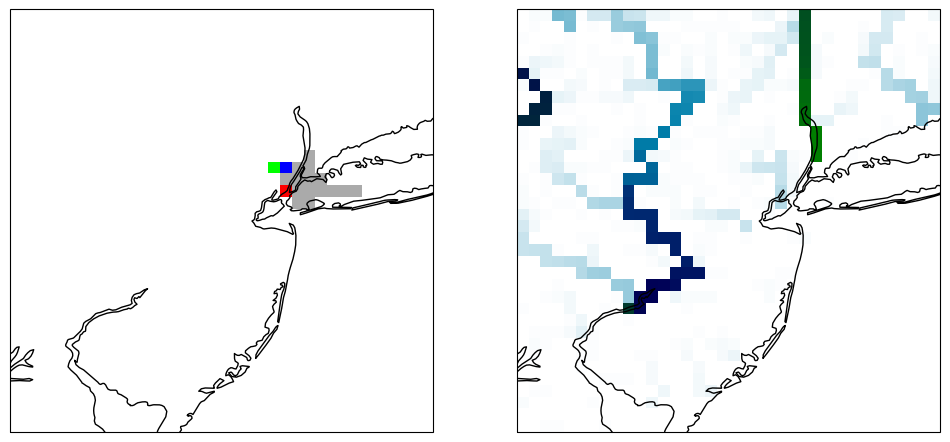

In [53]:
city_num = 7
left = -76
right = -73
bottom = 39
top = 42
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)

(array([18]), array([24]))


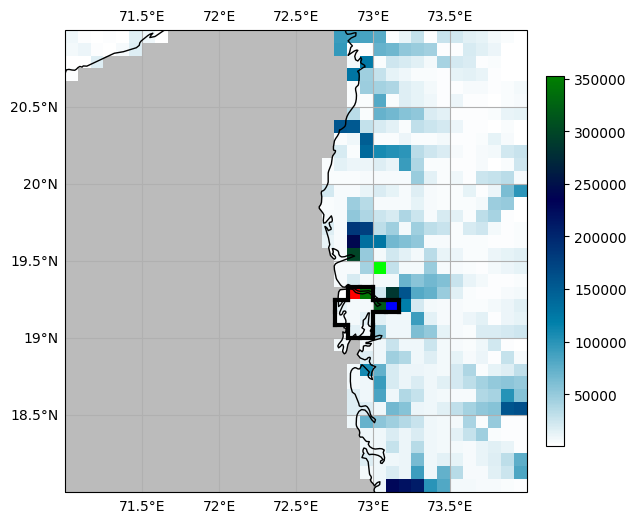

(array([18]), array([24]))


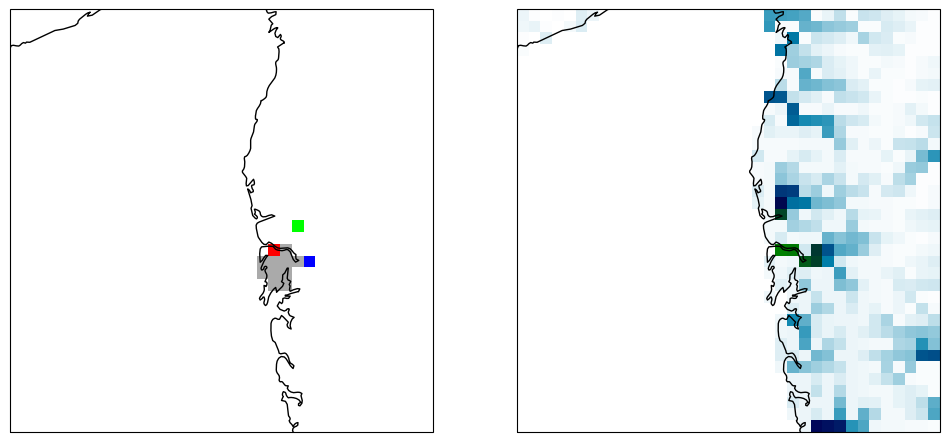

In [54]:
city_num = 8
left = 71
right = 74
bottom = 18
top = 21
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)

(array([14]), array([10]))


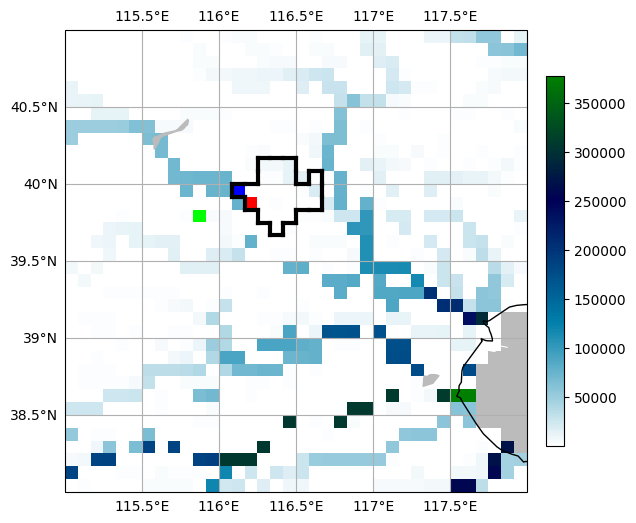

(array([14]), array([10]))


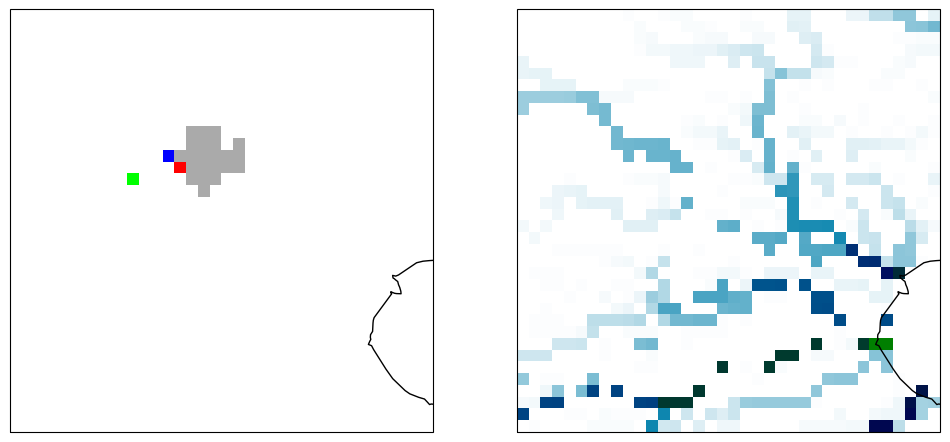

In [55]:
city_num = 10
left = 115
right = 118
bottom = 38
top = 41
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)

(array([8]), array([17]))


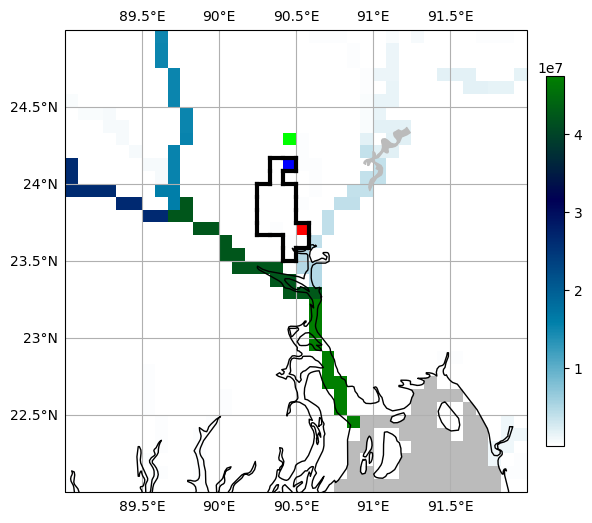

(array([8]), array([17]))


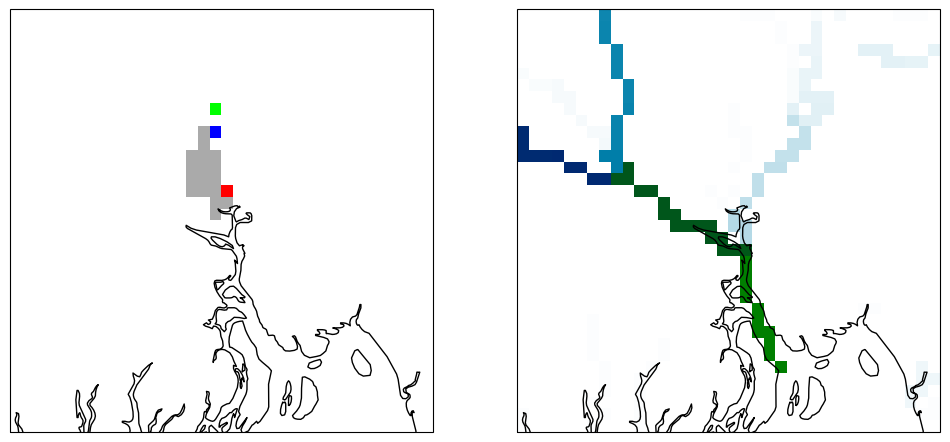

In [56]:
city_num = 11
left = 89
right = 92
bottom = 22
top = 25
int_samebasin(city_num, left, right, bottom, top)
josui_gesui(city_num, left, right, bottom, top)